**Постановка задачи:**

Предлагается поработать с банковскими данными и решить исследовательскую задачу: 


*   определить пол клиента по его финансовым тратам.


Основные данные представляют из себя историю банковских транзакций, а также демографическую информацию по некоторой выборке клиентов (данные обезличены и специальным образом искажены).


In [1]:
import pandas as pd
import numpy as np

import xgboost
from sklearn.metrics import accuracy_score
import sklearn.model_selection
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

Подгрузим исходные данные с gitHub репозитория:

In [2]:
url_customers_gender_train = 'https://raw.githubusercontent.com/Konstantan99/to-determine-the-gender-of-a-person/main/customers_gender_train.csv' 
customers_gender_train = pd.read_csv(url_customers_gender_train, delimiter=',')

url_tr_mcc_codes = 'https://raw.githubusercontent.com/Konstantan99/to-determine-the-gender-of-a-person/main/tr_mcc_codes.csv' 
tr_mcc_codes = pd.read_csv(url_tr_mcc_codes)
del tr_mcc_codes['Unnamed: 2']
del tr_mcc_codes['Unnamed: 3']
del tr_mcc_codes['Unnamed: 4']
del tr_mcc_codes['Unnamed: 5']

url_transactions = 'https://raw.githubusercontent.com/Konstantan99/to-determine-the-gender-of-a-person/main/transactions.csv' 
transactions = pd.read_csv(url_transactions)

print(
    '''
Размеры выборок, (объекты, признаки).
- customers_gender_train: {}
- tr_mcc_codes: {}
- transactions: {}
    '''.format(
        customers_gender_train.shape,  
        tr_mcc_codes.shape,
        transactions.shape
    )
)


Размеры выборок, (объекты, признаки).
- customers_gender_train: (12000, 2)
- tr_mcc_codes: (184, 2)
- transactions: (499999, 6)
    


# Описание таблиц

**ОПИСАНИЕ ИСХОДНЫХ ДАННЫХ**


---


**Таблица transactions.csv**

***Описание:*** Таблица содержит историю транзакций клиентов банка за один год и три месяца.

***Описание полей:***
*   customer_id — идентификатор клиента;
*   tr_datetime — день и время совершения транзакции (дни нумеруются с начала данных);
*   mcc_code — mcc-код транзакции;
*   tr_type — тип транзакции;
*   amount — сумма транзакции в условных единицах со знаком; + — начисление средств клиенту (приходная транзакция), - — списание средств (расходная транзакция);
*   term_id — идентификатор терминала;


---


***Таблица customers_gender_train.csv***

***Описание:*** Данная таблица содержит информацию по полу для части клиентов, для которых он известен. Для остальных клиентов пол необходимо предсказать в задаче A.

Описание полей:
*   customer_id — идентификатор клиента;
*   gender — пол клиента; 0 — женский, 1 — мужской;



---


**Таблица tr_mcc_codes.csv**

***Описание:*** Данная таблица содержит описание mcc-кодов транзакций.

Формат данных

mcc_code;mcc_description
1000;словесное описание mcc-кода 1000
2000;словесное описание mcc-кода 2000

Описание полей:
*   mcc_code – mcc-код транзакции;
*   mcc_description — описание mcc-кода транзакции.


---


**Таблица tr_types.csv**
***Описание:*** Данная таблица содержит описание типов транзакций.

Описание полей:
*   tr_type – тип транзакции;
*   tr_description — описание типа транзакции.

In [3]:
customers_gender_train.head(5)

,customer_id,gender
0,75562265,0
1,10928546,1
2,69348468,1
3,84816985,1
4,61009479,0


In [4]:
transactions.head(5)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN


In [5]:
tr_mcc_codes.head(5)

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,Генеральные подрядчики по вентиляции
2,1731,Подрядчики по электричеству
3,1799,Подрядчики
4,2741,Разнообразные издательства/печатное дело


# Предобработка исходных данных

Оставляем те строки, по которым мы знаем пол из таблицы `customers_gender_train`. 

Для Y значений также оставляем только те, по которым мы имеем транзакции

In [6]:
needed_transaction = transactions[transactions['customer_id'].isin(customers_gender_train['customer_id'])]
Y = customers_gender_train[customers_gender_train['customer_id'].isin(needed_transaction['customer_id'])]

Разделим столбец `tr_datetime` из вида `"1 10:20:56"`	на день и время

In [7]:
time_df = needed_transaction['tr_datetime'].str.split(' ', expand=True) #разделяем временной столбец на день и время
time_df.columns=['number_day','time']
needed_transaction = pd.concat([needed_transaction, time_df], axis=1)
del needed_transaction['tr_datetime']

#преобразуем данные в нужные форматы
needed_transaction['number_day'] = pd.to_numeric(needed_transaction['number_day'])

In [8]:
needed_transaction.head()

,customer_id,mcc_code,tr_type,amount,term_id,number_day,time
0,39026145,4814,1030,-2245.92,NaN,0,10:23:26
1,39026145,6011,7010,56147.89,NaN,1,10:19:29
2,39026145,4829,2330,-56147.89,NaN,1,10:20:56
3,39026145,5499,1010,-1392.47,NaN,1,10:39:54
4,39026145,5499,1010,-920.83,NaN,2,15:33:42


# Определение времени по исходным данным

Рассмотрим транзакции из флористики 

In [9]:
transactions_floristic = transactions[transactions['mcc_code'] == 5992]
time_df = transactions_floristic['tr_datetime'].str.split(' ', expand=True) #разделяем временной столбец на день и время
time_df.columns=['number_day','time']
transactions_floristic = pd.concat([transactions_floristic, time_df], axis=1)
transactions_floristic['number_day'] = pd.to_numeric(transactions_floristic['number_day'])

df_for_plot = pd.DataFrame(transactions_floristic['number_day'].value_counts()) #определяем сколько прошло транзакций в каждый по счету день 
df_for_plot = df_for_plot.reset_index()
df_for_plot.columns = ['day','count_day']
df_for_plot['percent_transactions'] = df_for_plot['count_day'] / df_for_plot['count_day'].sum() * 100 #определяем относительное количество покупок

df_for_plot = df_for_plot.sort_values('day', ascending=True) #сортируем день по возрастанию

In [10]:
# Создание фигуры точечного графика
fig = go.Figure(data=go.Scatter(
    x=df_for_plot['day'], y=df_for_plot['percent_transactions']
))
# Добавление подписей для графика
fig.update_layout(
    title_font_size=20,
    xaxis_title="День по счету",
    yaxis_title="Количество транзакций",  
)
# Отображение графика
fig.show()

Первый пик произошел на 30 день после начала, на последний пик произошел на 396 день (ровно через 363 дня). На 197 и 218 день с интервалом 22 дня также наблюдается два наибольших значения, если посчитать разницу в днях между 8 марта и 14 февраля - получится также 22 дня. Первому и последнему наивысших точек соостветствует 1 сенятбря.

**Следовательно, начало отчета - 1 августа**

# Составление признаков на подготовленных данных

## Количество транзакций клиента по каждому типу транзакций

Перестроим датафрейм: с группируем данные для каждого покупателя, и посмотрим сколько покупок совершенно в каждом типе транзакций (mcc_code)

In [11]:
X = needed_transaction.groupby('customer_id') \
                    .apply(lambda x: x[['mcc_code']].unstack().value_counts()) \
                    .unstack() \
                    .fillna(0)

Сортируем данные по `customer_id`, чтоб правильно сопоставить признаки с искомым признаком (пол клиента) 

In [12]:
X = X.sort_values(by='customer_id')
Y = Y.sort_values(by='customer_id')
X.head()

,742,1711,1799,2741,3000,3351,3501,4111,4112,4121,4131,4214,4215,4411,4511,4722,4784,4789,4812,4814,4816,4829,4899,4900,5013,5039,5044,5045,5047,5065,5072,5074,5085,5094,5099,5111,5122,5131,5137,5169,...,7375,7395,7399,7512,7523,7531,7538,7542,7629,7699,7829,7832,7841,7922,7932,7933,7991,7993,7994,7995,7996,7997,7999,8011,8021,8043,8062,8071,8099,8220,8244,8299,8398,8641,8699,8999,9222,9311,9399,9402
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
115617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,450.0,0.0,65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,113.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0
350821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,50.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


## Признаки по тратам и поступлениям

Разделим все транзакции на траты и поступления

In [13]:
income_transactions = needed_transaction[needed_transaction['amount'] > 0]
expenses_transactions = needed_transaction[needed_transaction['amount'] < 0]

Для каждого вида по каждому клиенту определим:


*   Максимальное значение (для трат - минимальное)
*   Среднее значение
*   Медианное значение
*   Стандартное отклонение
*   Количество транзакций
*   Общая сумма





In [14]:
income_df = income_transactions.groupby('customer_id').agg({'amount': ['count', 'sum', 'max', 'mean', 'median', 'std']})
income_df.columns=['count_income','sum_income','max_income','mean_income','median_income','std_income']

In [15]:
income_df = income_df[income_df['count_income'] < 300]
income_df = income_df[income_df['median_income'] < 600000]
income_df = income_df[income_df['sum_income'] < 75000000]
income_df = income_df[income_df['max_income'] < 15000000]

In [16]:
X_for_plot = income_df.merge(Y, on='customer_id', how='left')
X_for_plot = X_for_plot.fillna(0)

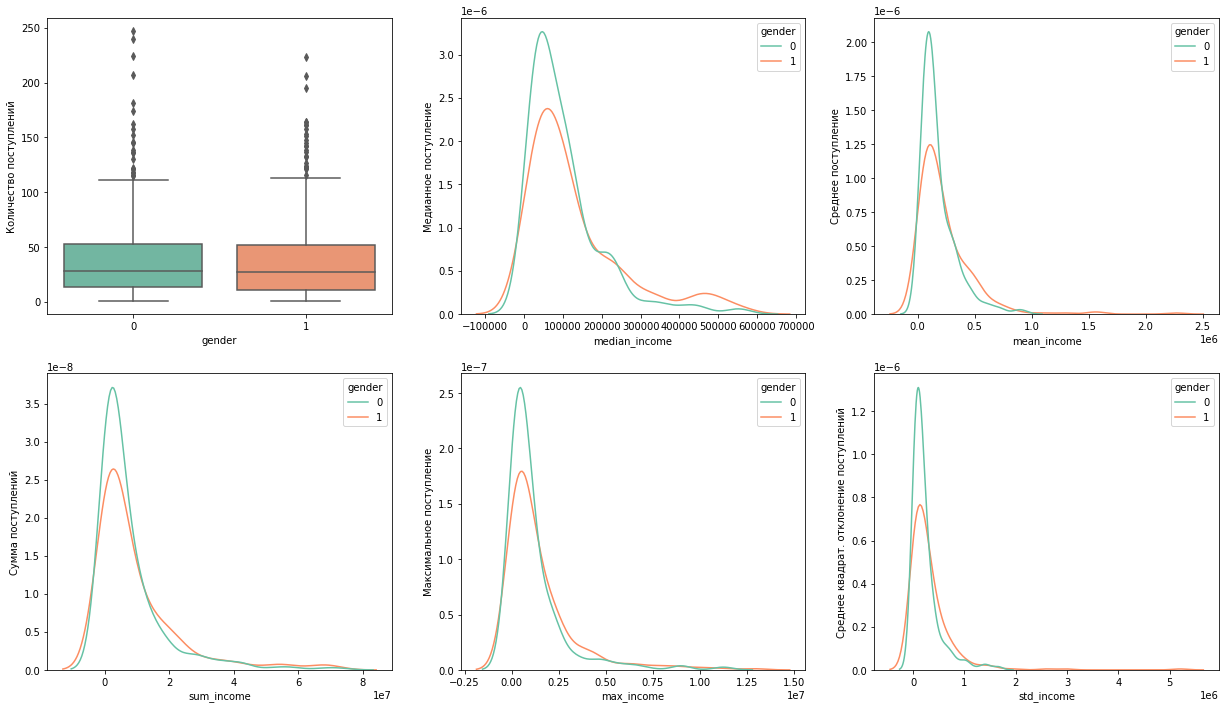

In [17]:
plt.figure(figsize=(21, 12))

plt.subplot(231)
ax = sns.boxplot(x=X_for_plot['gender'], y=X_for_plot['count_income'], palette='Set2')
plt.ylabel('Количество поступлений')

plt.subplot(232)
ax = sns.kdeplot(x='median_income', hue='gender', data=X_for_plot, palette='Set2')
plt.ylabel('Медианное поступление')

plt.subplot(233)
ax = sns.kdeplot(x='mean_income', hue='gender', data=X_for_plot, palette='Set2')
plt.ylabel('Среднее поступление')

plt.subplot(234)
ax = sns.kdeplot(x='sum_income', hue='gender', data=X_for_plot, palette='Set2')
plt.ylabel('Сумма поступлений')

plt.subplot(235)
ax = sns.kdeplot(x='max_income', hue='gender', data=X_for_plot, palette='Set2')
plt.ylabel('Максимальное поступление');

plt.subplot(236)
ax = sns.kdeplot(x='std_income', hue='gender', data=X_for_plot, palette='Set2')
plt.ylabel('Среднее квадрат. отклонение поступлений');

Точно такой же анализ проведем для трат:

In [18]:
expense_df = expenses_transactions.groupby('customer_id').agg({'amount': ['count', 'sum', 'min', 'mean', 'median', 'std']})
expense_df.columns=['count_expense', 'sum_expense','max_expense','mean_expense','median_expense','std_expense']

In [19]:
X2_for_plot = expense_df.merge(Y, on='customer_id', how='left')
X2_for_plot = X2_for_plot.fillna(0)

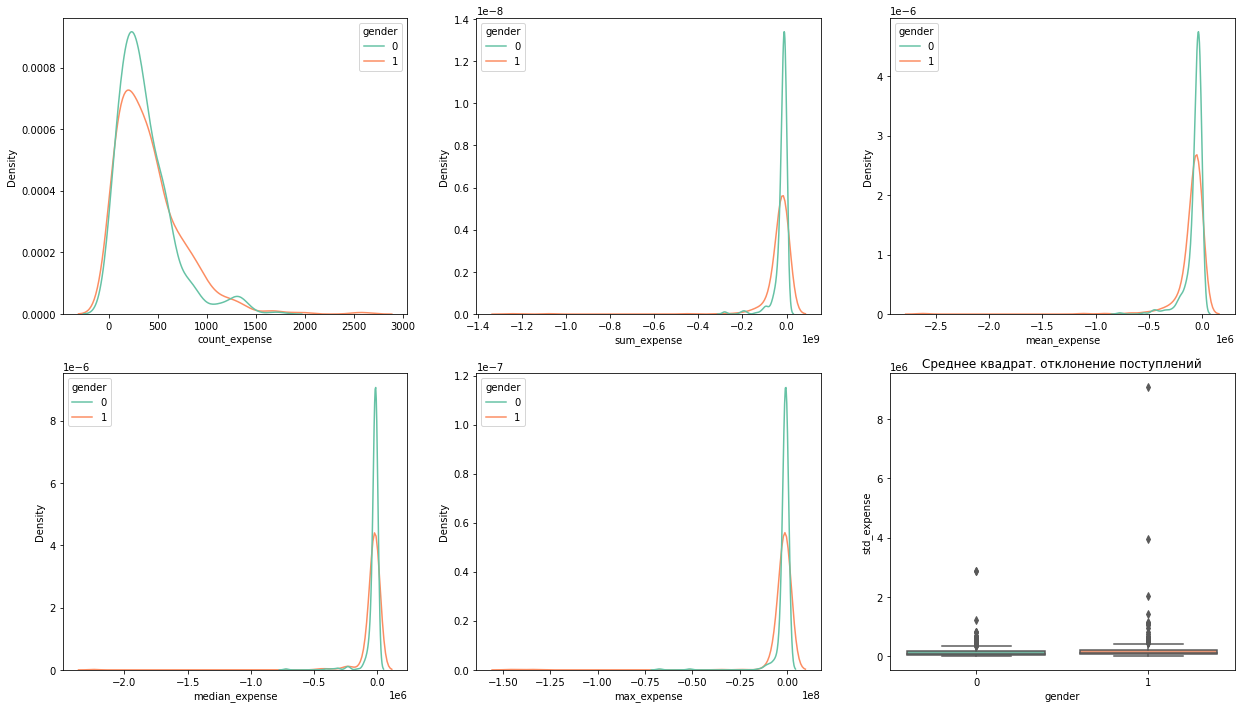

In [20]:
plt.figure(figsize=(21, 12))

plt.subplot(231)
ax = sns.kdeplot(x='count_expense', hue='gender', data=X2_for_plot, palette='Set2')

plt.subplot(232)
ax = sns.kdeplot(x='sum_expense', hue='gender', data=X2_for_plot, palette='Set2')

plt.subplot(233)
ax = sns.kdeplot(x='mean_expense', hue='gender', data=X2_for_plot, palette='Set2')

plt.subplot(234)
ax = sns.kdeplot(x='median_expense', hue='gender', data=X2_for_plot, palette='Set2')

plt.subplot(235)
ax = sns.kdeplot(x='max_expense', hue='gender', data=X2_for_plot, palette='Set2')

plt.subplot(236)
ax = sns.boxplot(x=X2_for_plot['gender'], y=X2_for_plot['std_expense'], palette='Set2')
plt.title(r'Среднее квадрат. отклонение поступлений');

#ax = sns.kdeplot(x='std_expense', hue='gender', data=X2_for_plot, palette='Set2')

In [21]:
#добавить общие?

Присоеденим полученные признаки к датафрейму `Х`:

In [22]:
X = X.merge(income_df, on='customer_id', how='left')
X = X.merge(expense_df, on='customer_id', how='left')
X = X.fillna(0) #заполним пустые ячейки (клиенты, у которых остутсвуют доходы или расходы, или стандартное отклонение равно нулю)

del Y['customer_id'] #удаляем столбец customer_id за ненадобностью

# Разбиение данных на train и test. Подбор гиперпараметров 

In [23]:
# split data into train and test sets
seed = 7
test_size = 0.15
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)

In [24]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import logging as lgr

dtrain = xgboost.DMatrix(X_train, Y_train)

def score(params):
  seed = int(np.random.rand()*100000)
  params['max_depth'] = int(params['max_depth'])
  lgr.info('seed = %i' % seed)
  lgr. info ("Training with params: ")
  lgr.info(params)
  cv_res = xgboost.cv(params, dtrain, early_stopping_rounds=100, maximize=True, 
                  num_boost_round=10000, nfold=5, seed = seed) 
  score = cv_res['test-auc-mean'].max() 
  lgr.info("Score = %f" % score)
  lgr.info('best rounds = %i' % cv_res[cv_res['test-auc-mean'] == cv_res['test-auc-mean'].max()].index[0])

  return {'loss': -score, 'status': STATUS_OK}

Функция оценки возвращает результат со знаком минус — это сделано специально, т.к. hyperopt минимизирует функционал, а нам надо максимизировать точность.

In [ ]:
space = {
    'eta' : hp.quniform('eta', 0.001, 0.1, 0.001),
    'max_depth' : hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 30, 1),
    'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
    'gamma' : hp.quniform('gamma', 0.1, 2, 0.05),
    'alpha': hp.quniform('alpha', 0.001, 2, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.01, 1, 0.01),
    'eval_metric': 'auc',
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'nthread' : 11,
    'silent' : 1
    }
trials = Trials() 
best = fmin(fn=score,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=40)

In [ ]:
print('''best parameters:
    alpha={}, 
    colsample_bytree={}, 
    eta={},
    gamma={},
    max_depth={}, 
    min_child_weight={}, 
    subsample={}
    '''.format(
        best['alpha'],
        best['colsample_bytree'],
        best['eta'],
        best['gamma'],
        round(best['max_depth']),
        best['min_child_weight'],
        best['subsample']
    ))

In [ ]:
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 
    :hp_results: результаты hyperop
    :return: pandas DataFrame
    """ 

    results = pd.DataFrame(hp_results)
    results['loss'] = results['loss'] * (-1)
    results.drop(labels=['status'], axis=1, inplace=True)
    return results

results = df_results(trials.results)

fig = go.Figure(data=go.Scatter(
    x=results.index, y=results['loss']
))
# Добавление подписей для графика
fig.update_layout(
    title_font_size=20,
    xaxis_title="Steps",
    yaxis_title="Loss",  
)
# Отображение графика
fig.show()

# Обучение модели

Настроим модель XGBClassifier с подобранными параметрами:


    alpha=0.9500000000000001, 
    colsample_bytree=0.08, 
    eta=0.022,
    gamma=1.4500000000000002,
    max_depth=15, 
    min_child_weight=26.0, 
    subsample=0.9500000000000001

    Accuracy: 83.93%
    ROC_AUC_score: 84.23%


In [26]:
# fit model no training data
model = xgboost.XGBClassifier(
      alpha=0.9500000000000001, 
      colsample_bytree=0.08, 
      eta=0.022,
      gamma=1.4500000000000002,
      max_depth=15, 
      min_child_weight=26.0, 
      subsample=0.9500000000000001
)
model.fit(X_train, Y_train.values.ravel())

# make predictions for test data
y_pred = model.predict(X_test)

predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

roc_auc = sklearn.metrics.roc_auc_score(Y_test, predictions)
print("ROC_AUC_score: %.2f%%" % (roc_auc * 100.0))

Accuracy: 83.93%
ROC_AUC_score: 84.23%


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



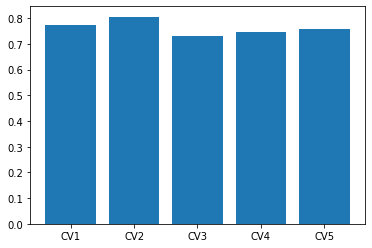

Значения cross-validation: [0.77181208 0.80536913 0.73154362 0.74496644 0.75838926]
Среднее cross-validation: 0.7624161073825503


In [27]:
from sklearn.model_selection import cross_val_score

all_accuracies = cross_val_score(estimator=model, 
                                 X=X, 
                                 y=Y, 
                                 cv=5)

x = range(len(all_accuracies))
ax = plt.gca()
ax.bar(x, all_accuracies)  #align='edge' - выравнивание по границе, а не по центру
ax.set_xticks(x)
ax.set_xticklabels(('CV1', 'CV2', 'CV3', 'CV4', 'CV5'))
plt.show()

print("Значения cross-validation:", all_accuracies)
print("Среднее cross-validation:",all_accuracies.mean())

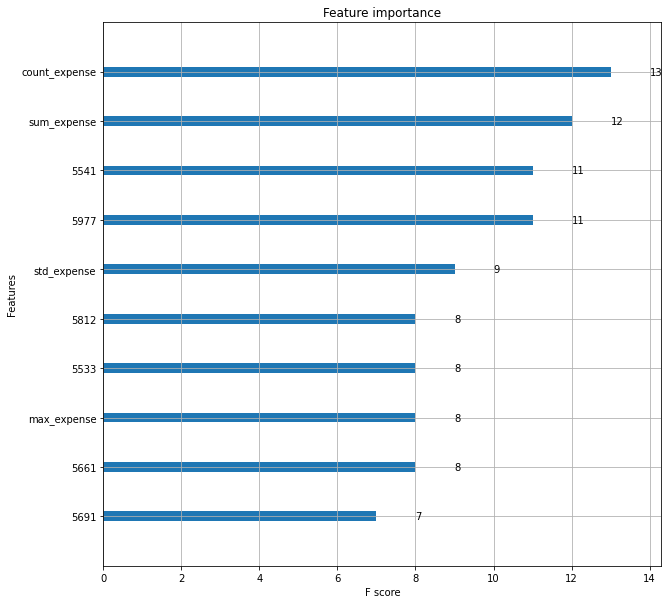

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgboost.plot_importance(model, max_num_features=10, ax=ax)

In [29]:
tr_mcc_codes[tr_mcc_codes['mcc_code'].isin([5541, 5977, 5812, 5533, 5561, 5691])]

,mcc_code,mcc_description
64,5533,Автозапчасти и аксессуары
65,5541,Станции техобслуживания
77,5691,Магазины мужской и женской одежды
90,5812,Места общественного питания
116,5977,Магазины косметики


Также можно рассмотреть фичи по времени:
*   По часам
*   Будни-выходные
*   Дням недели